With PU, additional track veto and correct proportions given the MC estimation

In [1]:
card_name = 'v4'

In [2]:
fit_real_data = False

In [3]:
trgMu_pt_region = 'mid'

# Import

In [4]:
import sys, os, pickle
from glob import glob
sys.path.append('../lib')
import itertools
import json
from IPython.display import IFrame, Image, display
from multiprocessing import Pool

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import interp1d
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics
from gridVarQ2Plot import plot_gridVarQ2
from progressBar import ProgressBar

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if fit_real_data:
    CMS_lumi.extraText = "Preliminary"
else:
    CMS_lumi.extraText = "Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Define binning

In [6]:
binning = {
    'q2'      : array('d', [-2, 1.5, 4, 6, 12]),
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, 0.8, 0.4)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 1.6, 0.4)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 3.0, 0.4)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.2, 0.4)) + [6] ),
    ],
    'Est_mu'  : [
        array('d', [0.5] + list(np.arange(0.8, 2.3, 0.1)) + [2.5] ),
        array('d', [0.5] + list(np.arange(0.8, 2.5, 0.1)) + [2.5] ),
        [20, 0.50, 2.500],
        [20, 0.50, 2.500],
    ]
}

# Create histograms file

In [7]:
file_loc = {
'mu'   : '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'tau'  : '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'Hc'   : '../data/cmsMC_private/BPH_Tag-B0_DmstHc-pD0bar-kp-Hc2mu_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'Dstst': '../data/cmsMC_private/BPH_Tag-Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root'
}
if fit_real_data:
    file_loc['data'] = '../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_191126_CAND.root'

In [9]:
def trigger_selection(ev):        
    if trgMu_pt_region == 'high':
        aux = ev.trgMu_HLT_Mu12_IP6 == 1
        aux &= ev.trgMu_pt > 12.1
    elif trgMu_pt_region == 'mid':
        aux = ev.trgMu_HLT_Mu12_IP6 == 0
        aux &= ev.trgMu_HLT_Mu9_IP6 == 1
        aux &= ev.trgMu_pt > 9.1
        aux &= ev.trgMu_pt < 11.9

    aux &= ev.trgMu_sigdxy > 7
    return aux

In [10]:
def candidate_selection(j, ev):
    aux = ev.pval_piK[j] > 0.1
    aux &= ev.K_pt[j] > 0.8
    aux &= abs(ev.K_eta[j]) < 2.5
    aux &= ev.pi_pt[j] > 0.8
    aux &= abs(ev.pi_eta[j]) < 2.5
    aux &= abs(ev.mass_piK[j] - 1.86) < 0.04
    if not aux: 
        return False

    aux = ev.pis_pt[j] > 0.5
    aux &= ev.pval_D0pis[j] > 0.1
    aux &= abs(ev.mass_D0pis[j] - 2.01) < 0.03
    aux &= ev.sigdxy_pis_PV[j] > 2
    aux &= ev.mass_D0pis[j] < ev.mass_piK[j] + 0.16
    aux &= ev.pval_D0pismu[j] > 0.1
    aux &= ev.cos_D0pismu_PV[j] > 0.99
    aux &= ev.q2_D0pismu[j] > binning['q2'][0]
    aux &= ev.q2_D0pismu[j] < binning['q2'][-1]
    aux &= ev.mass_D0pismu[j] < 7.
    if not aux: 
        return False
    
    if not ev.nTksAdd[j] == 0:
        idx_st = int(np.sum(ev.nTksAdd[:j]))
        # DEBUG controlla questa linea la prossima volta che fai le ntuple
        idx_stop = min(ev.tksAdd_massVis.size(), int(idx_st + ev.nTksAdd[j]))
        for jj in range(idx_st, idx_stop):
            if ev.tksAdd_massVis[jj] < 5.28:
                return False
    
    return True

In [11]:
def create_dSet(inputs, serial=False):
    n = inputs[0]
    filepath = inputs[1]
#     dSet = inputs[2]
    
    print n
    fskimmed_name = '../data/_root/skimmed4combine/' + n + '.root'
    if os.path.isfile(fskimmed_name) and not n in recreate:
        dSet[n] = rtnp.root2array(fskimmed_name)
    else:
        tree = rt.TChain('outA/Tevts')
        for fn in glob(filepath):
            tree.Add(fn)
        N_cand_in = tree.GetEntries()
        print n, ': Number of candidate events:', N_cand_in
    
        if serial:
            pb = ProgressBar(maxEntry=tree.GetEntries())
        else:
            maxEntry = float(tree.GetEntries())
            perc = int(maxEntry*0.1)
        N_accepted_cand = []
        output = []
        for i_ev, ev in enumerate(tree):
            if serial:
                pb.show(i_ev)
            elif i_ev % perc == 0:
                print n, ': {:.0f}%'.format(100*(i_ev+1)/maxEntry)
            N_acc = 0
            
            if not trigger_selection(ev): 
                continue
                
            for j in range(ev.pval_piK.size()):
                if not candidate_selection(j, ev):
                    continue
                    
                N_acc += 1
                aux = (ev.q2_D0pismu[j], ev.Est_mu_D0pismu[j], ev.M2_miss_D0pismu[j])
                aux += (ev.trgMu_pt, ev.trgMu_sigdxy)
                if not n == 'data':
                    aux += (ev.MC_B_pt, ev.MC_B_eta)
                if n in ['tau', 'mu']:
                    aux += (
                           ev.wh_CLNCentral,
                           ev.wh_CLNR0Down,
                           ev.wh_CLNR0Up,
                           ev.wh_CLNR1Down,
                           ev.wh_CLNR1Up,
                           ev.wh_CLNR2Down,
                           ev.wh_CLNR2Up,
                           ev.wh_CLNRhoSqDown,
                           ev.wh_CLNRhoSqUp,
                    )
                
                output.append(aux)
            
            if N_acc > 0:
                N_accepted_cand.append(N_acc)
        
        print n, ': Loop done'
        leafs_names = ['q2', 'Est_mu', 'M2_miss', 'trgMu_pt', 'trgMu_sigdxy']
        if not n == 'data':
            leafs_names += ['MC_B_pt', 'MC_B_eta']
        if n in ['tau', 'mu']:
            leafs_names += ['wh_CLNCentral', 'wh_CLNR0Down', 'wh_CLNR0Up', 'wh_CLNR1Down', 'wh_CLNR1Up', 'wh_CLNR2Down', 'wh_CLNR2Up', 'wh_CLNRhoSqDown', 'wh_CLNRhoSqUp']

        dtypes = []
        for nl in leafs_names:
            dtypes.append((nl, np.float32))
            
        dSet[n] = np.array(output, dtype=dtypes)
        if not os.path.isdir(os.path.dirname(fskimmed_name)):
            os.makedirs(os.path.dirname(fskimmed_name))
        rtnp.array2root(dSet[n], fskimmed_name, treename='Tevts', mode='RECREATE')
        
    aux = dSet[n].dtype.fields.keys()[0]
    print n, ': Events:', dSet[n][aux].shape[0]
    print ''

In [12]:
dSet = {}
recreate = [] #file_loc.keys()
inputs = [[n, fp] for n, fp in file_loc.iteritems()]

# p = Pool(len(inputs))
# out = p.map(create_dSet, inputs) 

for i in inputs:
    create_dSet(i, serial=True)

mu
mu : Events: 22655

tau
tau : Events: 5580

Dstst
Dstst : Events: 2237

Hc
Hc : Events: 2709



In [13]:
# Run plot_scripts/generation_breakdown_crab.ipynb to updated this file
dic_MCeff = pickle.load(open('../data/SignalRegionMC_efficiencies_PU20.pickle', 'rb'))

# This is always good unless one of the EvtGen card is changed
dic_decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

In [14]:
for n, d in dic_MCeff.iteritems():
    d['analysisSelEff'] = dSet[n]['q2'].shape[0]/float(d['TotCand'])

In [16]:
class PTCalibration:
    def __init__(self, calibration_dic=None, calibration_file=None):
        if not calibration_dic is None:
            self.calibration_dic = calibration_dic
            d = calibration_dic
        elif not calibration_file is None:
            d = {}
            lines = open(calibration_file, 'r').readlines()
            keys = lines[0][1:-1].split('\t')
            for k in keys: d[k] = []
            
            for l in lines[1:]:
                l = l[:-1]
                v = l.split('\t')
                for i in range(len(v)):
                    d[keys[i]].append(float(v[i]))
            
            self.calibration_dic = d
        else:
            raise
        
        self.f = {}
        self.f['C'] = interp1d(d['pt'], d['w'], 
                               fill_value=(d['w'][0], d['w'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Up'] = interp1d(d['pt'], d['wUp'], 
                               fill_value=(d['wUp'][0], d['wUp'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Down'] = interp1d(d['pt'], d['wDown'], 
                               fill_value=(d['wDown'][0], d['wDown'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
fname = '../data/calibration/B02JPsiKst_Mu12_pt.txt'
if trgMu_pt_region == 'mid':
    fname = '../data/calibration/B02JPsiKst_Mu9_pt.txt'
cal_pT = PTCalibration(calibration_file=fname)

In [17]:
histo = {}
for i_q2 in range(len(binning['q2'])-1):
    q2_l = binning['q2'][i_q2]
    q2_h = binning['q2'][i_q2 + 1]

    for var in ['M2_miss', 'Est_mu']:
        cat_name = var+'_q2bin'+str(i_q2)
        histo[cat_name] = {}
        for k,d in dSet.iteritems():          
            q2_bin = np.logical_and(d['q2'] > q2_l, d['q2'] < q2_h)
            
            if k == 'data':
                histo[cat_name][k] = create_TH1D(d[var][q2_bin], 
                                                 name='data_obs', title='Data Obs',
                                                 binning=binning[var][i_q2],
                                                 opt='underflow,overflow'
                                                )
            elif k in ['mu', 'tau']:
                for k_wpT in ['C', 'Up', 'Down']:
                    pFF_list = ['Central']
                    if k_wpT == 'C':
                        pFF_list += ['R0', 'R1', 'R2', 'RhoSq']
                    for n_pFF in pFF_list:
                        var_pFF_list = [''] if n_pFF == 'Central' else ['Up', 'Down']
                        for var_pFF in var_pFF_list:
                            h_name = k
                            if k_wpT != 'C':
                                h_name += '__B0pT' + k_wpT
                            elif n_pFF != 'Central':
                                h_name += '__B2DstCLN' + n_pFF + var_pFF

                            w = cal_pT.f[k_wpT](d['MC_B_pt'])
                            w *= d['wh_CLN'+n_pFF+var_pFF]
                            norm = np.sum(w)
                            w = w[q2_bin]
                            
                            h = create_TH1D(d[var][q2_bin], name=h_name, title=h_name, 
                                            binning=binning[var][i_q2], 
                                            opt='underflow,overflow',
                                            weights=w,
                                            scale_histo=1./norm,
                                           )

                            histo[cat_name][h_name] = h
            elif k in ['Hc']:
                for k_wpT in ['C', 'Up', 'Down']:
                    h_name = k
                    if k_wpT != 'C':
                        h_name += '__B0pT' + k_wpT
                        
                    w = cal_pT.f[k_wpT](d['MC_B_pt'][q2_bin])
                    
                    norm = np.sum(cal_pT.f[k_wpT](d['MC_B_pt']))
                    h = create_TH1D(d[var][q2_bin], name=h_name, title=h_name, 
                                    binning=binning[var][i_q2], 
                                    opt='underflow,overflow',
                                    weights=w,
                                    scale_histo=1./norm,
                                   )
                    
                    histo[cat_name][h_name] = h
            elif k in ['Dstst']:
                norm = float(d[var].shape[0])
                h = create_TH1D(d[var][q2_bin], name=k, title=k, 
                                binning=binning[var][i_q2], 
                                opt='underflow,overflow',
                                scale_histo=1./norm,
                               )
                histo[cat_name][k] = h

Generate Pseudo-data

In [18]:
expected_evts = {}
for n in dSet.keys():
    print '--->', n
    xsec_eff = dic_MCeff[n]['xsec']
    print 'Pythia xsec: {:1.2e} pb'.format(xsec_eff)
    xsec_eff *= dic_decayBR[n]
    print 'Forced decays BR: {:1.2e}'.format(dic_decayBR[n])
    xsec_eff *= dic_MCeff[n]['CMSSWFilterEff']
    print'Eff CMSSW filter: {:1.2e}'.format(dic_MCeff[n]['CMSSWFilterEff'])
    xsec_eff *= dic_MCeff[n]['ntupplizerEff']
    print'Eff ntuplizer: {:1.2e}'.format(dic_MCeff[n]['ntupplizerEff'])
    xsec_eff *= dic_MCeff[n]['analysisSelEff']
    print'Eff selection: {:1.2e}'.format(dic_MCeff[n]['analysisSelEff'])
    xsec_eff *= 1e3 # pb -> fb
    print '\nExpected evts/fb: {:.0f}'.format(xsec_eff)
    print '\n'
    expected_evts[n] = xsec_eff

---> mu
Pythia xsec: 1.49e+08 pb
Forced decays BR: 1.35e-03
Eff CMSSW filter: 7.03e-03
Eff ntuplizer: 2.02e-02
Eff selection: 1.03e-01

Expected evts/fb: 2931


---> tau
Pythia xsec: 1.49e+08 pb
Forced decays BR: 2.35e-04
Eff CMSSW filter: 1.33e-03
Eff ntuplizer: 2.51e-02
Eff selection: 1.15e-01

Expected evts/fb: 135


---> Hc
Pythia xsec: 1.49e+08 pb
Forced decays BR: 1.73e-04
Eff CMSSW filter: 5.03e-04
Eff ntuplizer: 2.42e-02
Eff selection: 7.81e-02

Expected evts/fb: 24


---> Dstst
Pythia xsec: 1.49e+08 pb
Forced decays BR: 1.80e-04
Eff CMSSW filter: 4.88e-03
Eff ntuplizer: 2.03e-02
Eff selection: 2.62e-02

Expected evts/fb: 70




In [19]:
rawR_exp = expected_evts['tau']/expected_evts['mu']
print 'Raw ratio: {:1.2e}'.format(rawR_exp)
f_Hc = expected_evts['Hc']/np.sum(expected_evts.values())
print 'f_Hc: {:1.2e}'.format(f_Hc)
f_Dstst = expected_evts['Dstst']/np.sum(expected_evts.values())
print 'f_Dstst: {:1.2e}'.format(f_Dstst)

f_bkg = f_Hc + f_Dstst
if fit_real_data:
    from lumi_utilities import getLumiReport
    lumi_tot, lumi_dic = getLumiReport(glob(file_loc['data']))
else:    
    lumi_tot = 40. #fb-1
    if trgMu_pt_region == 'high':
        N_exp_data = 98500
    elif trgMu_pt_region == 'mid':
        N_exp_data = 47000
    N_exp = N_exp_data*lumi_tot/5.25
    N_B2mu_inj = N_exp*(1-f_bkg)/(1+rawR_exp)

    n_mu = np.random.poisson(lam=N_B2mu_inj)
    w_mu = []
    sum_w_mu = 0
    idx_mu = []
    print('Generating {:.1f}k pseudo-events of mu'.format(n_mu*1.0e-3))
    pb = ProgressBar(n_mu)
    while sum_w_mu < n_mu:
        pb.show(np.ceil(sum_w_mu))
        i = np.random.randint(0, dSet['mu']['q2'].shape[0], size=(1, ))[0]
        w = cal_pT.f['C'](dSet['mu']['MC_B_pt'][i])
        w *= dSet['mu']['wh_CLNCentral'][i]
        idx_mu.append(i)
        w_mu.append(w)
        sum_w_mu += w
    pb.show(n_mu-1)

    n_tau = np.random.poisson(lam=N_B2mu_inj*rawR_exp)
    w_tau = []
    idx_tau = []
    print('Generating {:.1f}k pseudo-events of tau'.format(n_tau*1.0e-3))
    pb = ProgressBar(n_tau)
    pb.show(0)
    while np.sum(w_tau) < n_tau:
        pb.show(np.sum(w_tau))
        i = np.random.randint(0, dSet['tau']['q2'].shape[0], size=(1, ))[0]
        w = cal_pT.f['C'](dSet['tau']['MC_B_pt'][i])
        w *= dSet['tau']['wh_CLNCentral'][i]
        idx_tau.append(i)
        w_tau.append(w)
    pb.show(n_tau-1)
    
    n_Hc = np.random.poisson(lam=N_exp*f_Hc)
    w_Hc = []
    idx_Hc = []
    print('Generating {:.1f}k pseudo-events of Hc'.format(n_Hc*1.0e-3))
    pb = ProgressBar(n_Hc)
    while np.sum(w_Hc) < n_Hc:
        pb.show(np.sum(w_Hc))
        i = np.random.randint(0, dSet['Hc']['q2'].shape[0], size=(1, ))[0]
        w = cal_pT.f['C'](dSet['Hc']['MC_B_pt'][i])
        idx_Hc.append(i)
        w_Hc.append(w)
    pb.show(n_Hc-1)
    
    n_Dstst = np.random.poisson(lam=N_exp*f_Dstst)
    print('Generating {:.1f}k pseudo-events of Dstst'.format(n_Dstst*1.0e-3))
    idx_Dstst = np.random.randint(0, dSet['Dstst']['q2'].shape[0], size=(n_Dstst, ))

    pseudo_data = {}
    pseudo_w = np.array(w_mu + w_tau + w_Hc + [1.]*len(idx_Dstst))
    for var in binning.keys():
        pseudo_data[var] = np.concatenate((dSet['mu'][var][idx_mu], 
                                           dSet['tau'][var][idx_tau],
                                           dSet['Hc'][var][idx_Hc],
                                           dSet['Dstst'][var][idx_Dstst]
                                          ))

    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]

        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)

            sel = np.logical_and(pseudo_data['q2'] > q2_l, pseudo_data['q2'] < q2_h)
            
            h = create_TH1D(pseudo_data[var][sel], 
                            name='data_obs', title='data obs',
                            binning=binning[var][i_q2],
                            opt='underflow,overflow',
                            weights=pseudo_w[sel]
                           )
            h.Sumw2(0)
            for i in range(1, h.GetNbinsX()+1):
                h.SetBinContent(i, round(h.GetBinContent(i)))
            h.Sumw2()
            histo[cat_name]['data'] = h


    print 'r_toy = {:.2f}%'.format(100.*n_tau/n_mu)

Raw ratio: 4.61e-02
f_Hc: 7.72e-03
f_Dstst: 2.21e-02
Generating 332.1k pseudo-events of mu
[####################]  100% - Tot. time: 44.2 s  0%
[####################]  100% - Tot. time: 44.2 s
[####################]  100% - Tot. time: 44.2 s
Generating 15.4k pseudo-events of tau
[####################]  100% - Tot. time: 15.4 s  0%
Generating 2.7k pseudo-events of Hc
[####################]  100% - Tot. time: 0.7 s
Generating 8.0k pseudo-events of Dstst
r_toy = 4.63%


In [20]:
N_data = 0
N_mu = 0
N_tau = 0
N_Hc = 0
N_Dstst = 0
for k, h_dic in histo.iteritems():
    if 'Est_mu' in k:
        N_data += h_dic['data'].Integral()
        N_mu += h_dic['mu'].Integral()
        N_tau += h_dic['tau'].Integral()
        N_Hc += h_dic['Hc'].Integral()
        N_Dstst += h_dic['Dstst'].Integral()
N_B2mu_exp = N_data*(1-f_bkg)/(1+rawR_exp)

print 'Number of data events: {:.0f}'.format(N_data)
print 'Number of B0 -> D*munu expected: {:.0f}'.format(N_B2mu_exp)
print 'Total norm'
print 'Mu: {:.3f}'.format(N_mu)
print 'Tau: {:.3f}'.format(N_tau)
print 'Hc: {:.3f}'.format(N_Hc)
print 'Dstst: {:.3f}'.format(N_Dstst)

Number of data events: 358111
Number of B0 -> D*munu expected: 332124
Total norm
Mu: 1.000
Tau: 1.000
Hc: 1.000
Dstst: 1.000


In [21]:
histo_file_dir = '../data/_root/histos4combine/'
if not os.path.isdir(histo_file_dir):
    os.makedirs(histo_file_dir)
histo_file_loc = {}
for cat_name, h_dic in histo.iteritems():
    histo_file_loc[cat_name] = histo_file_dir+'{}_{}.root'.format(card_name, cat_name)
    tf = rt.TFile(histo_file_loc[cat_name], 'recreate')
    for v in h_dic.values():
        v.Write()
    tf.Close()

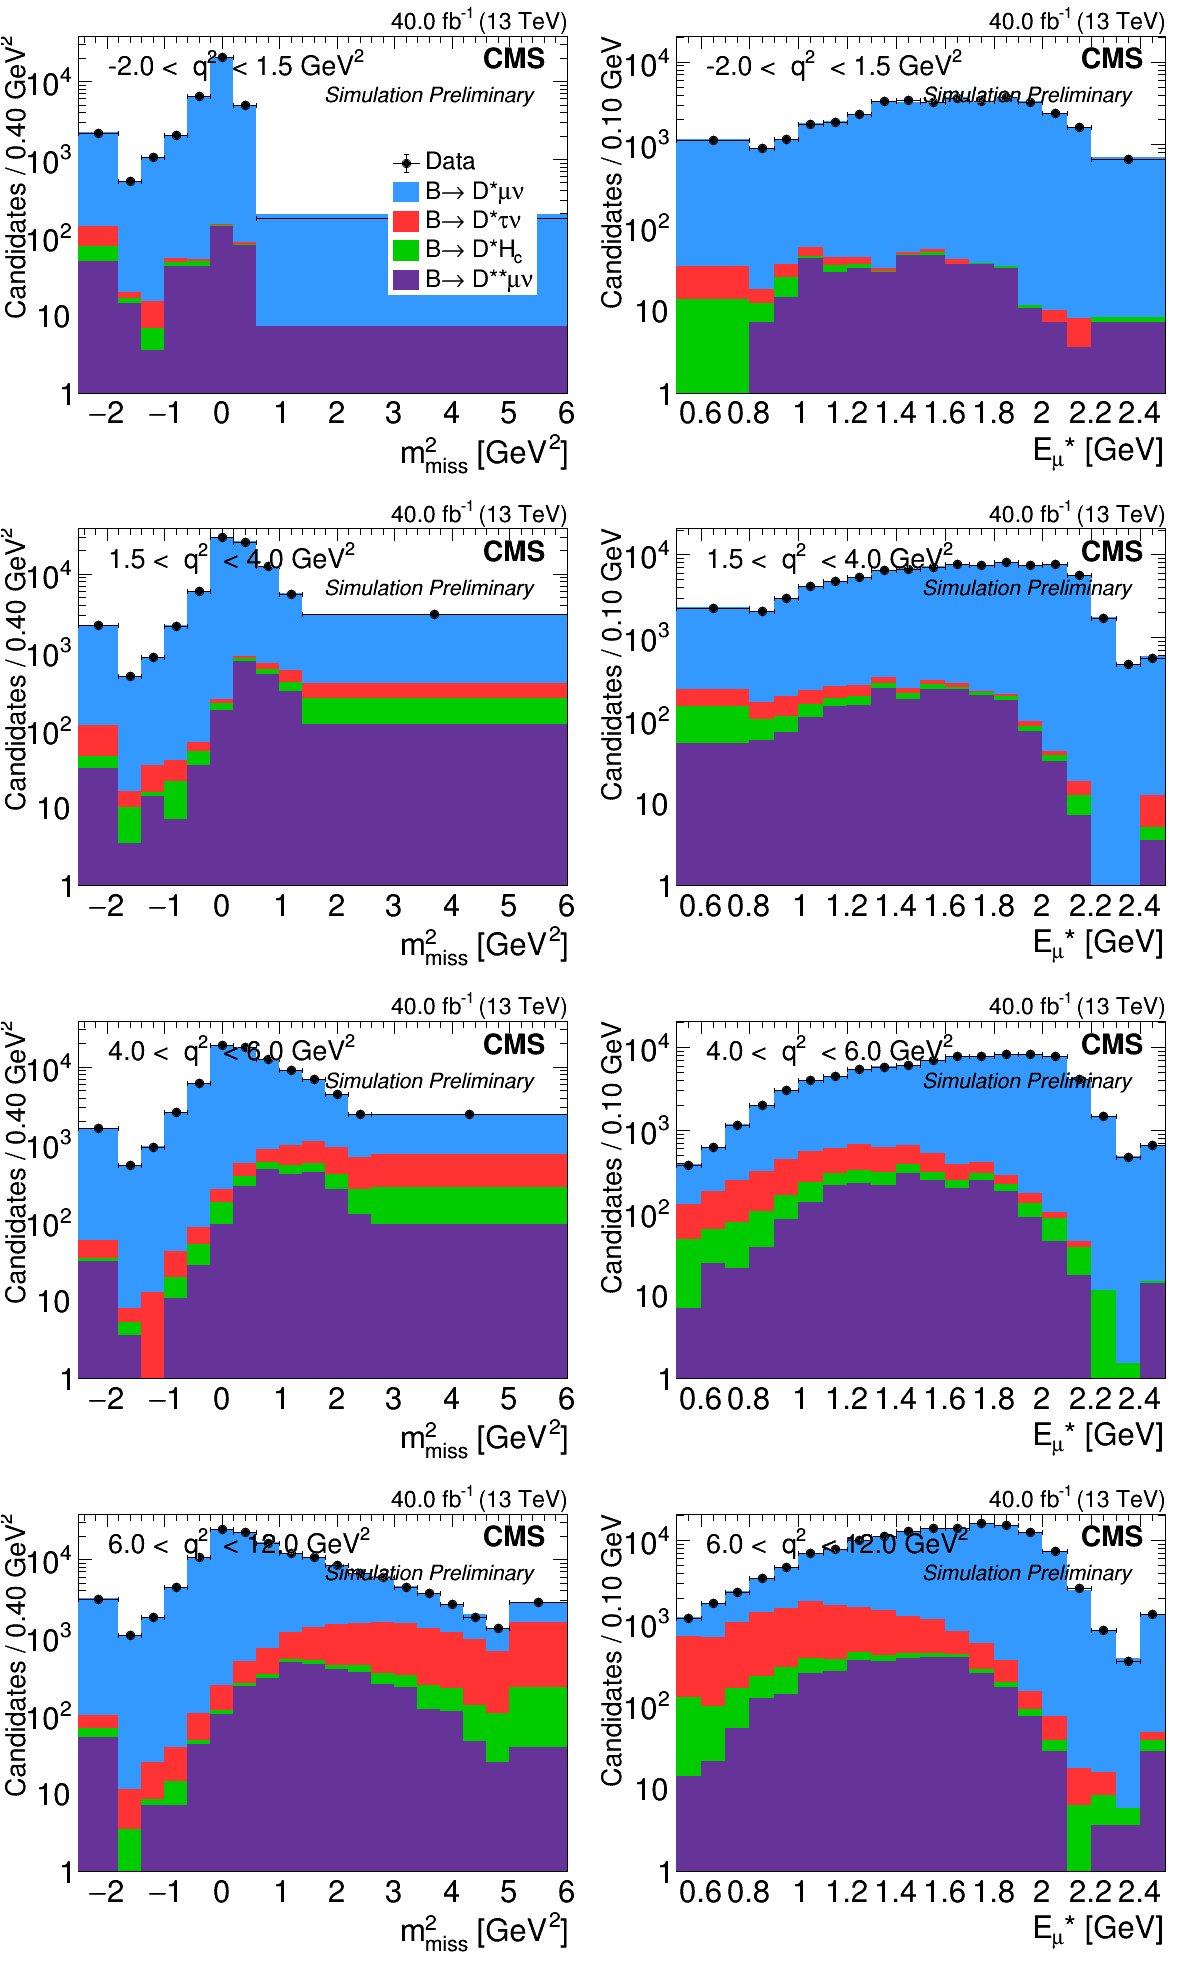

In [23]:
CMS_lumi.integrated_lumi = lumi_tot
scale_dic = {
    'tau': N_B2mu_exp*rawR_exp, 
    'mu' : N_B2mu_exp,
    'Hc' : N_data*f_Hc,
    'Dstst' : N_data*f_Dstst
            }

c = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic, min_y=1, logy=True)

# Write the card

In [24]:
sig_processes = ['tau', 'mu']
bkg_processes = ['Hc', 'Dstst']
processes = sig_processes + bkg_processes
categories = np.sort([k for k in histo.keys() if not '__' in k])

In [25]:
card_location = 'cards/{}.txt'.format(card_name)
fc = open(card_location, 'w')

In [26]:
# number of different categories
card = 'imax *\n'
# number of processes minus one
card += 'jmax {}\n'.format(len(processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += '--------------------------------------------------------------\n'

# shape file location
for k in categories:
    card += 'shapes * {} {} $PROCESS $PROCESS__$SYSTEMATIC\n'.format(k, histo_file_loc[k])
card += '--------------------------------------------------------------\n'

# number of events observed
card += 'bin ' + ' '.join(categories) + '\n'
obs = map(lambda k: '{:.0f}'.format(histo[k]['data'].Integral()), categories)
obs = ' '.join(obs)
card += 'observation ' + obs + '\n'
card += '--------------------------------------------------------------\n'


# MC expected events
aux_bin = ''
aux_proc_name = ''
aux_proc_id = ''
aux_proc_rate = ''
for c, p in itertools.product(categories, processes):
    aux_bin += ' '+c
    aux_proc_name += ' '+p
    aux_proc_id += ' '+str(np.argmax(np.array(processes) == p))
    aux_proc_rate += ' {:.4f}'.format(histo[c][p].Integral())
    
card += 'bin' + aux_bin + '\n'
card += 'process' + aux_proc_name + '\n'
# Zero or negative for sig and positive for bkg
card += 'process' + aux_proc_id + '\n'
# Expected rate
card += 'rate' + aux_proc_rate + '\n'
card += '--------------------------------------------------------------\n'

Add additional rate parameters

In [27]:
card += 'N_B2mu rateParam * tau {:.1f} [0,{:.0f}]\n'.format(scale_dic['mu'], 1.2*N_data)
card += 'N_B2mu rateParam * mu {:.1f} [0,{:.0f}]\n'.format(scale_dic['mu'], 1.2*N_data)
card += 'N_B2DstHc rateParam * Hc {:.1f} [0,{:.0f}]\n'.format(scale_dic['Hc'], 1.2*N_data)
card += 'N_B2Dstst rateParam * Dstst {:.1f} [0,{:.0f}]\n'.format(scale_dic['Dstst'], 1.2*N_data)
card += '--------------------------------------------------------------\n'

Systematics

In [28]:
aux_B0pT = ''
for c, p in itertools.product(categories, processes):
    if p in ['tau', 'mu', 'Hc']:
        aux_B0pT += ' 1.'
    else:
        aux_B0pT += ' -'
card += 'B0pT shape' + aux_B0pT + '\n'

In [29]:
for n_pFF in ['R0', 'R1', 'R2', 'RhoSq']:
    aux = ''
    for c, p in itertools.product(categories, processes):
        if p in ['tau', 'mu']:
            aux += ' 1.'
        else:
            aux += ' -'
    card += 'B2DstCLN{} shape'.format(n_pFF) + aux + '\n'

MC statistic systematics

In [30]:
card += '* autoMCStats 0 1 1\n'
card += '--------------------------------------------------------------\n'

Defining groups of systematics

In [31]:
# autoMCStats group = defined by default when using autoMCStats
card += 'B2DstFF group = B2DstCLN' + ' B2DstCLN'.join(['R0', 'R1', 'R2', 'RhoSq']) + '\n'
card += 'bkgMC_norm group = N_B2DstHc N_B2Dstst\n'
card += 'all_card group = N_B2mu N_B2DstHc N_B2Dstst B0pT\n'

In [32]:
print card

imax *
jmax 3
kmax *
--------------------------------------------------------------
shapes * Est_mu_q2bin0 ../data/_root/histos4combine/v4_Est_mu_q2bin0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin1 ../data/_root/histos4combine/v4_Est_mu_q2bin1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin2 ../data/_root/histos4combine/v4_Est_mu_q2bin2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin3 ../data/_root/histos4combine/v4_Est_mu_q2bin3.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin0 ../data/_root/histos4combine/v4_M2_miss_q2bin0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin1 ../data/_root/histos4combine/v4_M2_miss_q2bin1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin2 ../data/_root/histos4combine/v4_M2_miss_q2bin2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin3 ../data/_root/histos4combine/v4_M2_miss_q2bin3.root $PROCESS $PROCESS__$SYSTEMATIC
--------------------------------------------------------------
bin E

In [33]:
fc.write(card)
fc.close()

### Create output directory

In [34]:
outdir = 'results/' + card_name

if os.path.isdir(outdir):
    os.system('rm -rf ' + outdir)
os.system('mkdir ' + outdir);

# Run Combine

## Create the workspace

In [35]:
cmd = 'text2workspace.py ' + card_location 
cmd += ' -o ' + card_location.replace('.txt', '.root')
cmd += ' --no-b-only'
cmd += ' --verbose 1'
# cmd += ' --no-wrappers'
os.system(cmd)

0

Channel Est_mu_q2bin0 will use autoMCStats with settings: event-threshold=0, include-signal=1, hist-mode=1
Analysing bin errors for: prop_binEst_mu_q2bin0
Poisson cut-off: 0
Bin        Contents        Error           Notes                         
0          1584.778019     226.648283      total sum                     
0          49.000000       7.000000        Unweighted events, alpha=32.342409
  => Total parameter prop_binEst_mu_q2bin0_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1013.837316     154.198645      total sum                     
1          43.000000       6.557439        Unweighted events, alpha=23.577612
  => Total parameter prop_binEst_mu_q2bin0_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
2          1388.848353     179.882693      total sum                     
2          60.000000       7.745967        Unweighted events, alpha=

Creating pdfs for individual modes (8): .    1.    2.    3.    4.    5.    6.    7.    8done.
Importing combined pdf model_s


### Run the Maximum Likelyhood fit

In [36]:
cmd = 'combine'
cmd += ' -M FitDiagnostics'
cmd += ' --robustFit 1'
cmd += ' --skipBOnlyFit'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r={:.2f}'.format(rawR_exp)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu,N_B2DstHc,N_B2Dstst'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties'
cmd += ' --plots'
cmd += ' --verbose 1'

print cmd
os.system(cmd)
os.system('mv combine_logger.out ' + outdir + '/')
os.system('mv ./*.root ' + outdir + '/')

combine -M FitDiagnostics --robustFit 1 --skipBOnlyFit -d cards/v4.root -D data_obs --X-rtd MINIMIZER_analytic --setParameters r=0.05 --setParameterRanges r=0.001,1 --trackParameters N_B2mu,N_B2DstHc,N_B2Dstst -n v4 --out results/v4 --saveShapes --saveWithUncertainties --plots --verbose 1


0

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Turning on runtime-define MINIMIZER_analytic
 PDF CHECKING 
--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes:  [SnapShot_ExtRefClone,forceGenBinned] 
  Address: 0x911c1c0
  Clients: 
    (0x9215380,V-) RooSimultaneousOpt::model_s "model_s"
  Servers: 
    (0x911d7c0,V-) RooRealSumPdf::pdf_binEst_mu_q2bin0_nuis ""
    (0x94dfbb0,V-) RooProdPdf::pdfbins_binEst_mu_q2bin0 ""
    (0x8e70d70,V-) SimpleGaussianConstraint::B0pT_Pdf "B0pT_Pdf"
    (0x90d18c0,V-) SimpleGaussianConstraint::B2DstCLNR0_Pdf "B2DstCLNR0_Pdf"
    (0x90d5150,V-) SimpleGaussianConstraint::B2DstCLNR1_Pdf "B2DstCLNR1_Pdf"
    (0x90fcc50,V-) SimpleGaussianConstraint::B2DstCLNR2_Pdf "B2DstCLNR2_Pdf"
    (0x911aab0,V-) SimpleGaussianConstraint::B2DstCLNRhoSq_Pdf "B2DstCLNRhoSq_Pdf"
  Proxies: 
  

Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/cards/v4.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Error in <TList::Clear>: A list is accessing an object (0x955f0cc) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x955f374) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x955f61c) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x955f8c4) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x955fb6c) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x955fe14) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x95600bc) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x95

In [37]:
cmd = 'python diffNuisances.py '.format(os.environ['CMSSW_BASE'])
cmd += glob(outdir + '/fitDiagnostics{}.root'.format(card_name))[0]
cmd += ' --skipFitB'
cmd += ' -g {}/nuisance_pull.root'.format(outdir)
print cmd
os.system(cmd)

python diffNuisances.py results/v4/fitDiagnosticsv4.root --skipFitB -g results/v4/nuisance_pull.root


0

diffNuisances run on results/v4/fitDiagnosticsv4.root, at 2019-12-12 02:04:06.520393 with the following options ... {'absolute_values': False, 'show_all_parameters': False, 'format': 'text', 'stol2': 0.5, 'pullDef': '', 'vtol': 0.3, 'stol': 0.1, 'plotfile': 'results/v4/nuisance_pull.root', 'skipFitB': True, 'vtol2': 2.0, 'poi': 'r'}

name                                              b-only fit            s+b fit         rho
B0pT                                          ! -0.02, 0.05!     ! -0.02, 0.05!       -0.27
B2DstCLNR1                                    ! +0.11, 1.54!     ! +0.11, 1.54!       -0.34
B2DstCLNR2                                       +0.09, 0.64        +0.09, 0.64       -0.03
B2DstCLNRhoSq                                    +0.04, 1.20        +0.04, 1.20       +0.37
prop_binEst_mu_q2bin0_bin0                    ! +0.03, 0.31!     ! +0.03, 0.31!       +0.20
prop_binEst_mu_q2bin0_bin1                    ! +0.16, 0.26!     ! +0.16, 0.26!       +0.14
prop_binEst_mu_q2bin

r = 4.4 +0.4/-0.5 %
N_B2mu = 332651
N_B2DstHc = 3387
N_B2Dstst = 7476




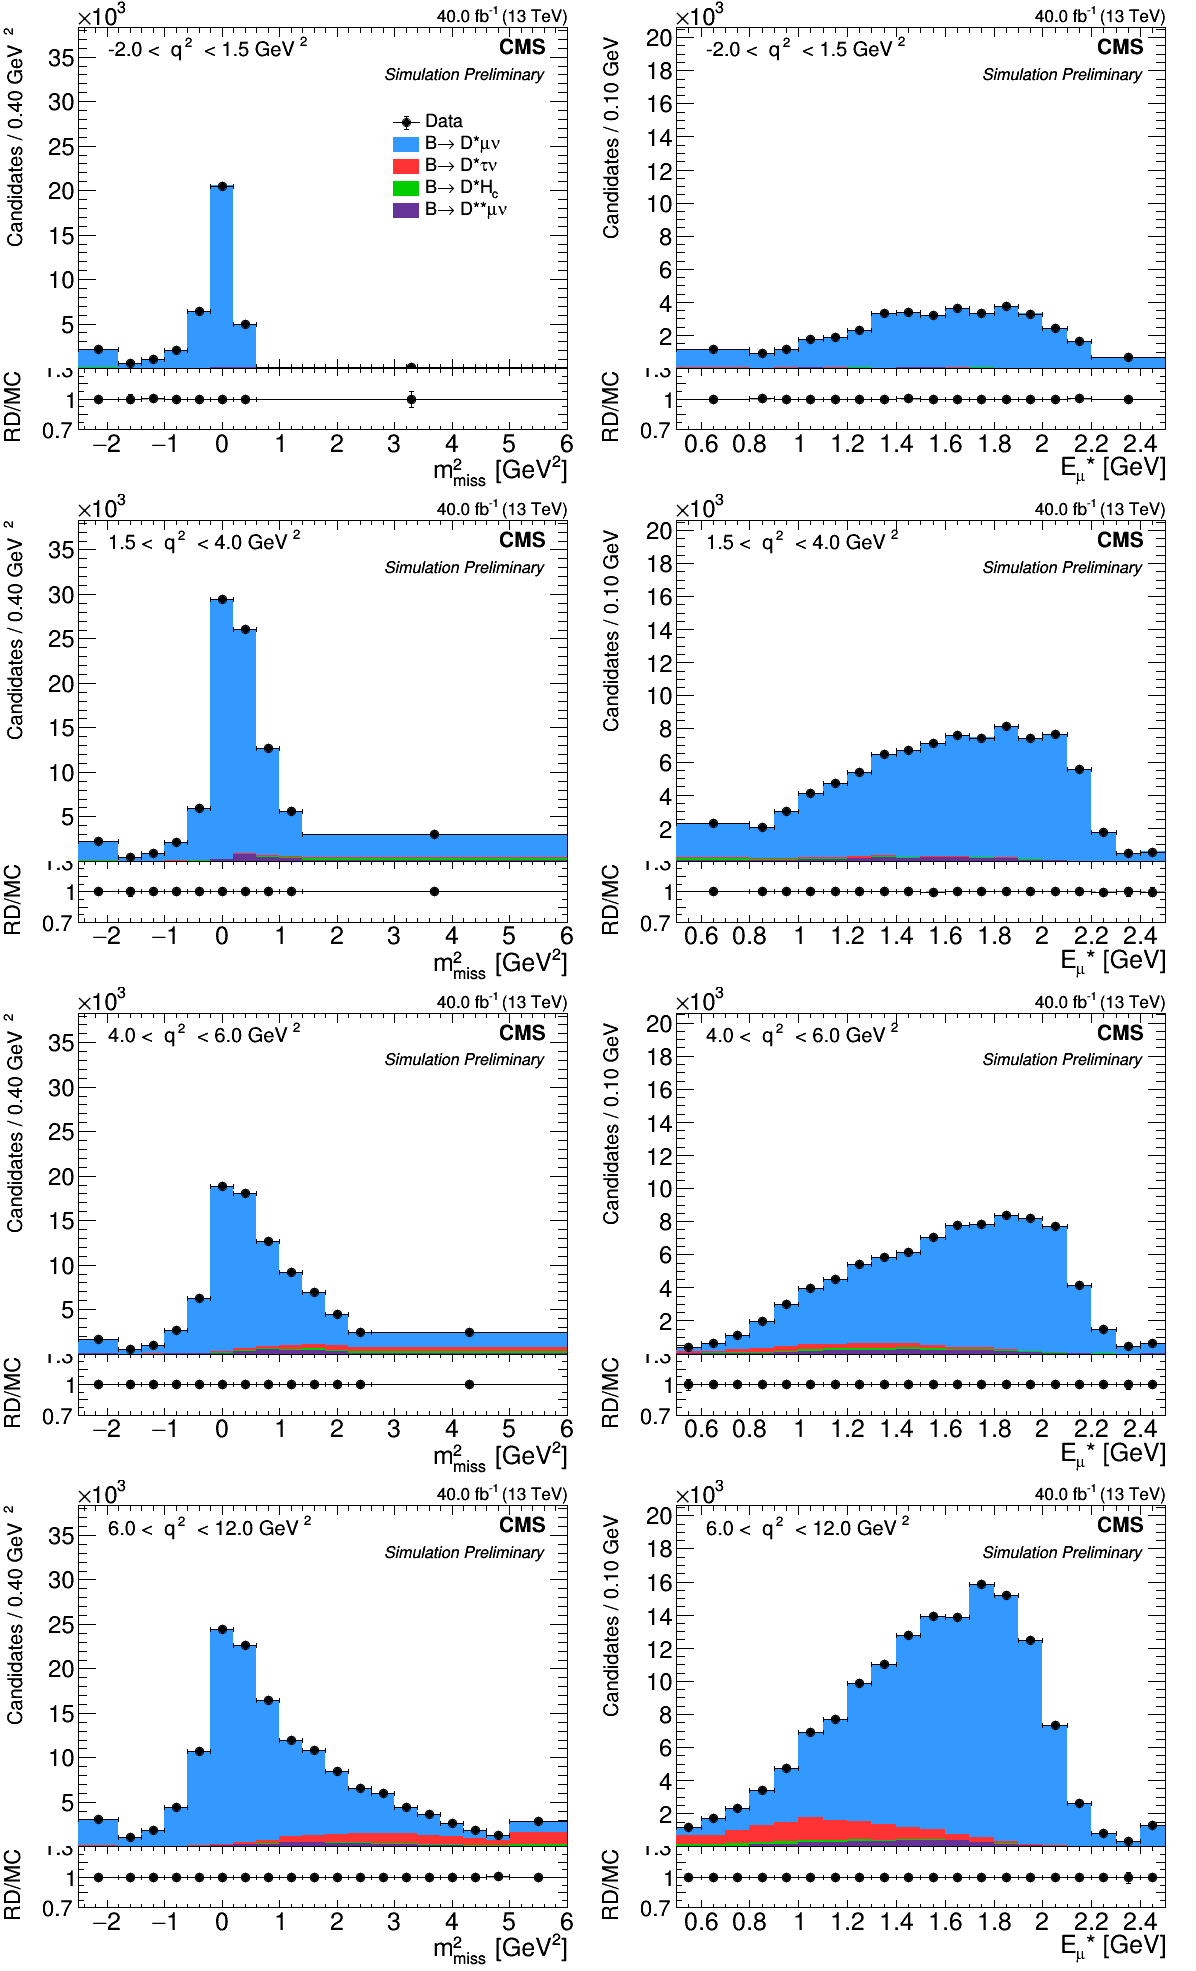

In [38]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.root'.format(card_name))[0])
c, d, u, _ = f['limit']['limit'].array()
print 'r = {:.1f} +{:.1f}/-{:.1f} %'.format(100*c, 100*(u-c), 100*(c-d))

N_B2mu = f['limit']['trackedParam_N_B2mu'].array()[0]
print 'N_B2mu = {:.0f}'.format(N_B2mu)
N_B2DstHc = f['limit']['trackedParam_N_B2DstHc'].array()[0]
print 'N_B2DstHc = {:.0f}'.format(N_B2DstHc)
N_B2Dstst = f['limit']['trackedParam_N_B2Dstst'].array()[0]
print 'N_B2Dstst = {:.0f}'.format(N_B2Dstst)

# Get post-fit shapes
f = rt.TFile(glob(outdir + '/fitDiagnostics{}.root'.format(card_name))[0], 'READ')
fd = f.shapes_fit_s

print '\n'
histo_postfit = {}
for cat, h_dic in histo.iteritems():
    histo_postfit[cat] = {}
    for n, h in h_dic.iteritems():
        if '__' in n:
            continue
        h_post = h.Clone(h.GetName() + '_postfit')
        if 'data' in n:
            h_fit = fd.Get(cat+'/total')
            h_data = h.Clone(h.GetName() + '_data')
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i))     
            
            histo_postfit[cat]['total'] = h_post
            histo_postfit[cat][n] = h_data
        else:
            h_fit = fd.Get(cat+'/'+n)
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i)) 

            histo_postfit[cat][n] = h_post
            
c_out = plot_gridVarQ2(CMS_lumi, binning, histo_postfit, scale_dic={}, draw_pulls=True)

### Run likelyhood scan

In [39]:
def getUncertainty(name, verbose=True):
    f = ur.open(name)
    r_arr = f['limit']['r'].array()
    nll_arr = f['limit']['deltaNLL'].array()
    c = r_arr[0]
    r_u = r_arr[r_arr>r_arr[0]]
    nll_u = nll_arr[r_arr>r_arr[0]]
    f_u = interp1d(nll_u, r_u, 'quadratic')
    u = f_u(0.5)
    r_l = r_arr[r_arr<r_arr[0]]
    nll_l = nll_arr[r_arr<r_arr[0]]
    f_l = interp1d(nll_l, r_l, 'quadratic')
    l = f_l(0.5)
    if verbose:
        print '----------------------------------'
        print 'r = {:.2f} +{:.2f}/-{:.2f} %'.format(100*c, 100*(u-c), 100*(c-l))
        print 'Sigma = {:.3f}'.format((u-l)*0.5)
        print '----------------------------------\n'
    return c, c-l, u-c, (u-l)*0.5

combine -M MultiDimFit --algo grid --points=100 --robustFit 1 -d cards/v4.root -D data_obs --X-rtd MINIMIZER_analytic --rMin=0.0212 --rMax=0.0666 -n v4_nominal --verbose -1
----------------------------------
r = 4.41 +0.45/-0.48 %
Sigma = 0.005
----------------------------------



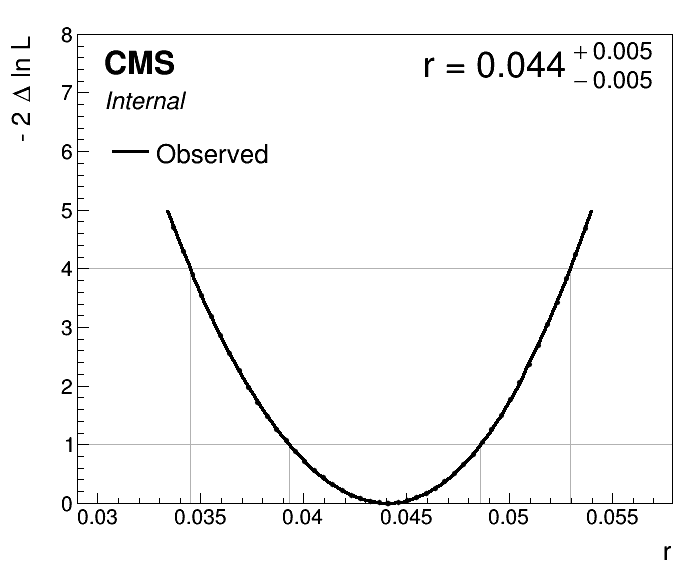

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 0.04 min (cpu), 0.04 min (real)
--------------------------------------
scan
--------------------------------------
[{'lo': 0.03928891952819877, 'hi': 0.048585325744357775, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.0344858501185251, 'hi': 0.052938023954772, 'valid_hi': True, 'valid_lo': True}]


Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [40]:
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=100'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(c - 5*(c-d), c + 5*(u-c))
cmd += ' -n {}_nominal'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd)
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += '; mv scan.png scan_nominal.png'
os.system(cmd)
res_nominal = getUncertainty('higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name))
display(Image(filename='scan_nominal.png'))

### Uncertainy breakdown by group

In [41]:
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo none'
cmd += ' --cminDefaultMinimizerStrategy=2'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --rMin=0 --rMax=1'
cmd += ' -n {}_bestfit'.format(card_name)
cmd += ' --saveWorkspace'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo none --cminDefaultMinimizerStrategy=2 --robustFit 1 -d cards/v4.root -D data_obs --X-rtd MINIMIZER_analytic --setParameters r=0.1 --rMin=0 --rMax=1 -n v4_bestfit --saveWorkspace --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
   r :    +0.044
Done in 0.00 min (cpu), 0.00 min (real)


combine -M MultiDimFit --algo grid --points=100 --cminDefaultMinimizerStrategy=2 --robustFit 1 -d higgsCombinev4_bestfit.MultiDimFit.mH120.root -D data_obs --X-rtd MINIMIZER_analytic --rMin=0.0212 --rMax=0.0666 -n v4_stat --snapshotName MultiDimFit --freezeParameters allConstrainedNuisances --verbose -1
----------------------------------
r = 4.41 +0.11/-0.11 %
Sigma = 0.001
----------------------------------

plot1DScan.py higgsCombinev4_nominal.MultiDimFit.mH120.root --others "higgsCombinev4_stat.MultiDimFit.mH120.root:Freeze all:2" --breakdown syst,stat; mv scan.png scan_stat.png


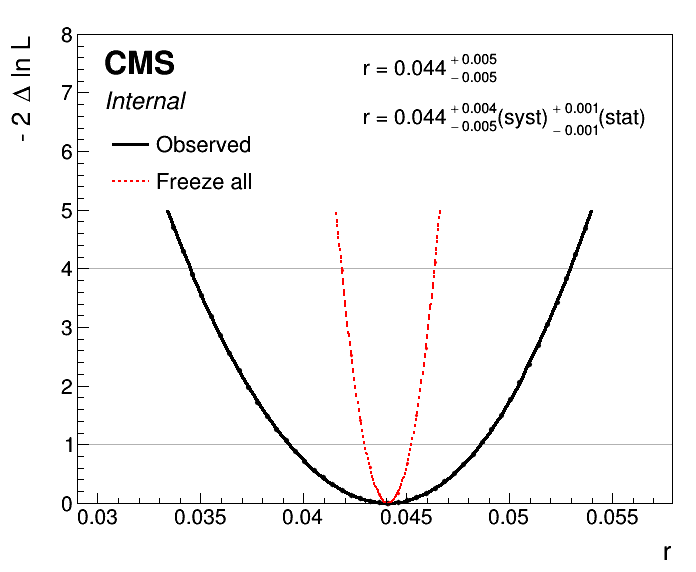

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 0.01 min (cpu), 0.01 min (real)
--------------------------------------
scan
--------------------------------------
[{'lo': 0.03928891952819877, 'hi': 0.048585325744357775, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.0344858501185251, 'hi': 0.052938023954772, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.0429778051509537, 'hi': 0.04523830581081923, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.04184752748201992, 'hi': 0.04636863525962753, 'valid_hi': True, 'valid_lo': True}]


Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [42]:
# Statistical uncertainty
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=2'
cmd += ' --robustFit 1'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(c - 5*(c-d), c + 5*(u-c))
cmd += ' -n {}_stat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeParameters allConstrainedNuisances'
cmd += ' --verbose -1'
print cmd
os.system(cmd);
res_stat = getUncertainty('higgsCombine{}_stat.MultiDimFit.mH120.root'.format(card_name))
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --others "higgsCombine{}_stat.MultiDimFit.mH120.root:Freeze all:2"'.format(card_name)
cmd += ' --breakdown syst,stat'
cmd += '; mv scan.png scan_stat.png'
print cmd
os.system(cmd)
display(Image(filename='scan_stat.png'))

combine -M MultiDimFit --algo grid --points=100 --cminDefaultMinimizerStrategy=2 --robustFit 1 -d higgsCombinev4_bestfit.MultiDimFit.mH120.root -D data_obs --X-rtd MINIMIZER_analytic --rMin=0.0212 --rMax=0.0666 -n v4_MCstat --snapshotName MultiDimFit --freezeNuisanceGroups=autoMCStats --verbose -1
----------------------------------
r = 4.41 +0.14/-0.16 %
Sigma = 0.001
----------------------------------

plot1DScan.py higgsCombinev4_nominal.MultiDimFit.mH120.root --others "higgsCombinev4_MCstat.MultiDimFit.mH120.root:Freeze MC stat:4" "higgsCombinev4_stat.MultiDimFit.mH120.root:Freeze all:2" --breakdown MCstat,syst,stat; mv scan.png scan_MCstat.png


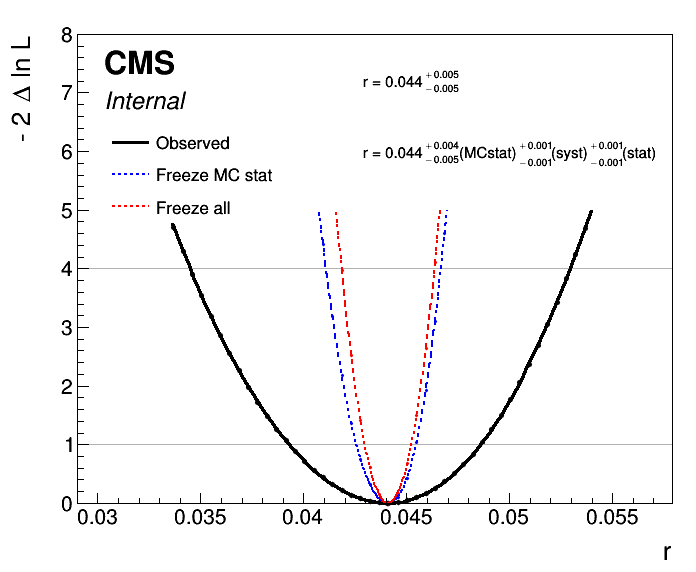

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 0.04 min (cpu), 0.04 min (real)
--------------------------------------
scan
--------------------------------------
[{'lo': 0.03928891952819877, 'hi': 0.048585325744357775, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.0344858501185251, 'hi': 0.052938023954772, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.04255906571650968, 'hi': 0.045470701683448786, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.04109266624545298, 'hi': 0.0466799371655454, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.0429778051509537, 'hi': 0.04523830581081923, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.04184752748201992, 'hi': 0.046368635

Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [43]:
# MC Statistics
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=2'
cmd += ' --robustFit 1'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(c - 5*(c-d), c + 5*(u-c))
cmd += ' -n {}_MCstat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeNuisanceGroups=autoMCStats'
cmd += ' --verbose -1'
print cmd
os.system(cmd);
res_MCstat = getUncertainty('higgsCombine{}_MCstat.MultiDimFit.mH120.root'.format(card_name))
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --others'
cmd += ' "higgsCombine{}_MCstat.MultiDimFit.mH120.root:Freeze MC stat:4"'.format(card_name)
cmd += ' "higgsCombine{}_stat.MultiDimFit.mH120.root:Freeze all:2"'.format(card_name)
cmd += ' --breakdown MCstat,syst,stat'
cmd += '; mv scan.png scan_MCstat.png'
print cmd
os.system(cmd)
display(Image(filename='scan_MCstat.png'))

In [44]:
os.system('mv higgsCombine*.root ' + outdir + '/')
os.system('mv scan* ' + outdir + '/')
os.system('mv combine_logger.out ' + outdir + '/');

### Run the pull/impact plots

Fit first the POI

In [ ]:
cmd = 'combineTool.py -M Impacts --doInitialFit -m 120'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r={:.2f}'.format(rawR_exp)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --verbose 0'
os.system(cmd)

 Perform a similar scan for each nuisance parameter

In [ ]:
cmd = 'combineTool.py -M Impacts --doFits -m 120'
cmd += ' --robustFit 1'
cmd += ' --parallel 8'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
# cmd += ' --setParameters r={:.2f}'.format(rawR_exp)
# cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --verbose 0'
print cmd
os.system(cmd)

Collect the results

In [ ]:
cmd = 'combineTool.py -M Impacts -o impacts.json -m 120'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
print cmd
os.system(cmd);

In [ ]:
rename = {
'B0pT': 'B_{0} p_{T} spectrum',
'N_B2mu':'N_{B#rightarrow D*#mu#nu}'
}
json.dump(rename, open('rename.json', 'w'))

cmd = 'plotImpacts.py -i impacts.json -o impacts -t rename.json'
os.system(cmd)
IFrame("impacts.pdf", width=900, height=600)

In [ ]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv impacts.* {}/'.format(outdir))
os.system('mv rename.json {}/'.format(outdir))
os.system('mv combine_logger.out {}/'.format(outdir));

### Run the Goodness of fit test

Run the observed test stat value

In [ ]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 9'

In [ ]:
print cmd
os.system(cmd)

Run the test stat toy distribution

In [ ]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 300'                                    # Number of toys to run
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
# cmd += '--expectSignal=0'                           # Depending on the hypothesis to test. If none, r is fluctruated
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 1'

In [ ]:
print cmd
os.system(cmd)

Combine them to get the p-value

In [ ]:
name_obs = glob('higgsCombineObs.GoodnessOfFit.*.root')[0]
# name_obs = glob(outdir+'/higgsCombineObs.GoodnessOfFit.*.root')[0]
name_toys = glob('higgsCombineToys.GoodnessOfFit.*.root')[0]
# name_toys = glob(outdir+'/higgsCombineToys.GoodnessOfFit.*.root')[0]

In [ ]:
f = ur.open(name_obs)
s_obs = f['limit']['limit'].array()[0]

f = ur.open(name_toys)
s_toys = f['limit']['limit'].array()

content, center, _ = plt.hist(s_toys, label='Toys')
plt.plot([s_obs, s_obs], [0, np.max(content)], 'm--', label='Observed')
plt.legend(loc='best')

p_val = np.sum(s_toys > s_obs)/float(s_toys.shape[0])
print 'p-value: {:.1f}%'.format(100*p_val)
if p_val < 0.01: print p_val

In [ ]:
# cmd = 'combineTool.py'
# cmd += ' -M CollectGoodnessOfFit'
# cmd += ' --mass 120'
# cmd += ' -o gof.json'
# cmd += ' --input {} {}'.format(name_obs, name_toys)
# print cmd
# os.system(cmd)
# os.system('plotGof.py gof.json -o gof --mass 120.0')

In [ ]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv *.dot {}/'.format(outdir))
os.system('mv *.out {}/'.format(outdir))